In [1]:
from fastai.text.all import *
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from train_model import get_x, get_y, get_items, SAM
from fastai.text.all import load_learner, tuplify

In [2]:
def get_preds_wrapper(learner, json_items):
    """
    Given a learner and a list of items in JSON format,
    this function prepares the items for prediction, gets the predictions,
    and then formats the predictions along with their confidences and finch_ids for return.

    Args:
        learner: The trained model that we want to use to make predictions.
        json_items: The items for which we want to make predictions, in JSON format. Each item
                     has values for finch_id, text, and a placeholder finch_cat_id.
                     The placeholder finch_cat_id can be anything, it's just for loading the items into
                     the dls without it getting mad

    Returns:
        A list of dictionaries, each containing a finch_id, predicted category, and confidence score.
    """
    # annoying batch hacK
    bs = learner.dls.bs
    batches = [json_items[i : i + bs] for i in range(0, len(json_items), bs)]
    response = []

    for batch in batches:

        dls = learner.dls.test_dl(batch, shuffle=False)

        # Extract finch_ids from the items in the dataloader
        finch_ids = [item["finch_id"] for item in dls.items]

        # Get the predictions from the learner, with input, target values,
        # decoded values, and confidence scores. reorder=True sorts the predictions in the original order of items
        inp, confs, _, cats = learner.get_preds(
            dl=dls, reorder=True, with_decoded=True, with_targs=True, with_input=True
        )

        # Decode the batch to transform the predictions to the original format, using the decode function of the dataloader
        decoded_output = learner.dls.decode_batch(
            (*tuplify(inp), *tuplify(cats)), max_n=len(inp)
        )
        cats = learner.dls.vocab[-1]

        # Combine finch_ids, decoded outputs, and confidences into a list of dictionaries for return
        for finch_id, out, conf in zip(finch_ids, decoded_output, confs):
            response.append(
                {
                    "finch_id": finch_id,
                    "predicted_cat": out[-1],
                    "input_text": out[0],
                    "confidence": {cat: c for cat, c in zip(cats, conf.tolist())},
                }
            )
    output_df = pd.DataFrame(response)

    output_df["predicted_confidence"] = [
        conf[pred_cat]
        for pred_cat, conf in zip(
            output_df["predicted_cat"], output_df["confidence"]
        )
    ]
    output_df = output_df[["finch_id", "predicted_cat", "predicted_confidence", "input_text"]]
        
    return output_df

In [3]:
def textify_data(df: pd.DataFrame):
    """
    This method loads the local data and turns the features we
    want to predict from into a single text field, clean and neat!
    """
    df.loc[:, "text"] = (
        df.loc[:, "name"].apply(str)
        + df.loc[:, "brand_name"].apply(str)
        + df.loc[:, "description"].apply(str)
        + df.loc[:, "features"].apply(str)
    )

    punc = lambda text: re.sub(
        r"[^a-zA-Z0-9:$-,%.?!]+", " ", text
    )  # remove uneccesary punctuation
    numb = lambda text: re.sub(r"[^a-zA-Z:$-,%.?!]+", " ", text)  # remove numbers
    link = lambda text: re.sub(r"http\S+", "", text)  # remove links
    lists = lambda text: re.sub(r"[\[\]\(\)\{}]", "", text)
    df.loc[:, "text"] = df.loc[:, "text"].apply(punc)
    df.loc[:, "text"] = df.loc[:, "text"].apply(numb)
    df.loc[:, "text"] = df.loc[:, "text"].apply(link)
    df.loc[:, "text"] = df.loc[:, "text"].apply(lists)

    # Convert text to lowercase
    df.loc[:, "text"] = df.loc[:, "text"].str.lower()

    # Remove stopwords
    stop = stopwords.words("english")
    df.loc[:, "text"] = df.loc[:, "text"].apply(
        lambda x: " ".join([word for word in x.split() if word not in (stop)])
    )

    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    df.loc[:, "text"] = df.loc[:, "text"].apply(
        lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
    )

    return df.loc[:, ["finch_cat_id", "text", "finch_id"]]

In [4]:
finch_categories = pd.read_csv("finch_categories.csv")

In [5]:
crib_mats = pd.read_csv("crib_mats.csv")
crib_mats = textify_data(crib_mats)
crib_mats_json = crib_mats.to_dict(orient = 'records')
crib_mats.head()

,finch_cat_id,text,finch_id
0,870e6274,"sheetworld % cotton percale extra deep fitted portable mini crib sheet x x . , patriotic stars, made usasheetworld.comfitted portable mini crib sheet measure x inch % cotton woven tc elastic around entire edge safe secure fit feature patriotic star machine washable dryable made usa! note: please make sure select proper fitted sheet mattress size. two different depth available. standard inch thick mattress, make sure select ' x x '. extra deep . mattress need extra deep fitted ' x x . ' size sheet. extra deep sheet work brand 'davinci extra deep mattress' well brands. measure x x . extra de...",amzn_us___B08L6W972N
1,870e6274,mh global crib size knife edge outdoor daybed mattress bolster insert cover complete set ad mh global crib size knife edge outdoor daybed mattress bolster insert cover complete set ad premium foam mattress foam density: . pcf high densityand dacron wrap layer foam mattress:foam + fiberfill + dacron wrap: x high density mattress foam cover : x x layer pillow insert:polyester fiberfill + fiber warp + dacron wrap x bolster pillow cover insert: x * gram fiberfill per bolster color: ad edge trim: knife edge packaging: vacuumpacked fabric: gram polyester upholstery water repellent *not water pro...,amzn_us___B09NN5RVKQ
2,870e6274,"organic crib mattress ecobabynancrib innerspring mattress extra firm . gauge coil gauge border rod organic cotton quilted layer organically processed wool quilted layer organic cotton damask outer. x x . organic crib mattress , coil firmness , quilted layer comfort , wool batting , organic cotton damask outer",amzn_us___B000YFRK7C
3,870e6274,dbm import style crib outdoor daybed mattress bolster knife edge insert cover complete set ad dbm importsstyle crib outdoor daybed mattress bolster knife edge insert cover complete set ad premium foam mattress foam density: . pcf high densityand dacron wrap layer foam mattress:foam + fiberfill + dacron wrap: x mattress foam cover dimension: x x layer pillow insert: polyester fiberfill + fiber warp + dacron wrap x bolster insert cover dimension gram fiberfill: x color: ad edge trim: knife edge packaging: vacuumpacked fabric: gram polyester upholstery hidden zipper water repellent *not water...,amzn_us___B09NN3BB1Z
4,870e6274,"sheetworld % cotton percale extra deep fitted portable mini crib sheet x x . , camel links, made usasheetworld.comfitted portable mini crib sheet measure x inch % cotton woven tc elastic around entire edge safe secure fit feature camel link machine washable dryable made usa! note: please make sure select proper fitted sheet mattress size. two different depth available. standard inch thick mattress, make sure select ' x x '. extra deep . mattress need extra deep fitted ' x x . ' size sheet. extra deep sheet work brand 'davinci extra deep mattress' well brands. measure x x . extra deep , % c...",amzn_us___B0BLWFJHFT


In [6]:
model_names = [
    "parent",
    "household_essentials",
    "baby",
    "pets",
    "home",
    "personal_care",
]
def setup_learner(model_name, model_path):
    assert model_name in model_names, model_name + " not found, nerd!"
    return load_learner(
        "./{model_path}/{model_name}_model.pkl".format(
            model_name=model_name, model_path = model_path
        )
    )

In [9]:
#this just shows the structure of the exploration project, we've got models for both T and TA
!tree

.
├── TA_models
│   ├── baby_model.pkl
│   ├── home_model.pkl
│   ├── household_essentials_model.pkl
│   ├── parent_model (1).pkl
│   ├── parent_model.pkl
│   ├── parent_model.pkl.pth
│   ├── personal_care_model.pkl
│   └── pets_model.pkl
├── T_models
│   ├── baby_model.pkl
│   ├── home_model.pkl
│   ├── household_essentials_model.pkl
│   ├── parent_model (1).pkl
│   ├── parent_model.pkl
│   ├── parent_model.pkl.pth
│   ├── personal_care_model.pkl
│   └── pets_model.pkl
├── __pycache__
│   └── train_model.cpython-37.pyc
├── crib_mats.csv
├── finch_categories.csv
├── ground_truth_baby.csv
├── ta vs t models.ipynb
└── train_model.py

3 directories, 22 files


In [10]:
ta_baby = setup_learner("baby", "TA_models" )
t_baby = setup_learner("baby", "T_models" )

In [11]:
ta_predictions = get_preds_wrapper(ta_baby, crib_mats_json).sort_values('predicted_confidence')
t_predictions = get_preds_wrapper(t_baby, crib_mats_json).sort_values('predicted_confidence')

In [12]:
ta_cats = ta_predictions.merge(finch_categories.rename(columns = {"finch_cat_id":"predicted_cat"}), on='predicted_cat', how='left')
t_cats = t_predictions.merge(finch_categories.rename(columns = {"finch_cat_id":"predicted_cat"}), on='predicted_cat', how='left')
t_cats.columns

Index(['finch_id', 'predicted_cat', 'predicted_confidence', 'input_text',
       'finch_cat_name', 'currently_scored', 'finch_cat_name_a',
       'finch_cat_id_a', 'finch_cat_name_b', 'finch_cat_id_b',
       'finch_cat_name_c', 'finch_cat_id_c'],
      dtype='object')

In [13]:
t_cats[['input_text', 'predicted_cat', 'finch_cat_name', 'predicted_confidence']][t_cats['predicted_confidence'] > 0.9]


,input_text,predicted_cat,finch_cat_name,predicted_confidence
68,"xxbos premium foam crib toddler mattress , non toxic , removable cover , washable baby mattress crib designed standard toddler bed mattress , light xxunk toddler mattress safe baby : crib mattress made non toxic foam material , free harmful material chemicals . , premium materials : baby mattress crib come premium foam , provides baby toddler healthier better sleep . , standard crib & toddler bed xxunk : suitable standard crib toddler beds . size toddler bed mattress x x inches . , easy xxunk : waterproof baby crib mattress cover removable . machine washable cold water .",870e6274,Crib Mattresses,0.902092
69,"xxbos dream sparkling dream crib toddler mattress , blue waterproof vinyl cover , greenguard gold jpma certified , copper infused toddler layer , maximum support xxunk xxunk little star glow sleep bring home dream sparkling dream infant toddler mattress . thoughtfully designed mattress , ultra firm fiber infant side , recommended pediatrician maximum support . copper infused toddler layer release moisture provides cooler natural surface sleepy baby . more , durable infant toddler mattress boast waterproof vinyl cover lock stitching ensures utmost safety child . proudly made usa , dream spa...",870e6274,Crib Mattresses,0.904816
70,"xxbos xxunk crib mattress , mattress pad topper child nursery mat floor mat safety mattress , foldable bed roll camping mattress floor lounger bed xxunk xxunk xxunk color fitted crib sheet bedding breathable extra soft fitted bed cover mattresses , bed mattresses , playard mattresses . brings good touch feel . high quality & safer , organic cotton ultra soft skin & hair color natural organic plants . exceptionally soft smooth , providing cozy comfortable feel sensitive skin hair . enjoy sweet dream safe comfy sheets . easy care & easy xxunk machine washable . fade quick drying . tumble dry...",46287a6a,Baby Bedding,0.908298
71,"xxbos dream snuggle extra firm fiber portable mini crib mattress xxunk , greenguard gold certified , soft breathable mesh cover , lightweight baby mattress xxunk xxunk whimsical xxunk fairy tale dream snuggle xxunk extra firm fiber mattress offer perfect sleep environment & support little one . crafted hold growing body little one , fit portable crib ! waterproof cover keep mattress fresh . made give little one easy rest , night . rest easy knowing mattress designed , engineered proudly made usa using best quality , environmentally friendly , meeting strict safety quality standards . vinyl...",870e6274,Crib Mattresses,0.910591
72,"xxbos xxunk % cotton percale extra deep fitted portable mini crib sheet x x . , xxunk stars , made xxunk portable mini crib sheet measure x inch % cotton woven xxunk elastic around entire edge safe secure fit feature xxunk star machine washable dryable made usa ! note : please make sure select proper fitted sheet mattress size . two different depth available . standard inch thick mattress , make sure select ' x x ' . extra deep . mattress need extra deep fitted ' x x . ' size sheet . extra deep sheet work brand ' davinci extra deep mattress ' well xxunk . measure x x . extra deep , % cotto...",46287a6a,Baby Bedding,0.912895
73,"xxbos xxunk % cotton percale extra deep fitted portable mini crib sheet x x . , grey polka xxunk , made xxunk portable mini crib sheet measure x inch % cotton woven xxunk elastic around entire edge safe secure fit feature grey polka dot machine washable dryable made usa ! note : please make sure select proper fitted sheet mattress size . two different depth available . standard inch thick mattress , make sure select ' x x ' . extra deep . mattress need extra deep fitted ' x x . ' size sheet . extra deep sheet work brand ' davinci extra deep mattress ' well xxunk . measure x x . extra deep ...",46287a6a,Baby Bedding,0.913809
74,"xxbos xxunk % cotton percale extra deep fitted portable mini crib sheet x x . , xxunk xxunk , made xxunk portable mini crib sheet m

In [14]:
ta_cats[['input_text', 'predicted_cat', 'finch_cat_name', 'predicted_confidence']][ta_cats['predicted_confidence'] > 0.9]

,input_text,predicted_cat,finch_cat_name,predicted_confidence
49,"xxbos xxunk baby bed mattress newborn nest removable washable baby pad room xxunk : made good quality polyester pp cotton , soft , skin friendly breathable . mattress washed directly water , easy deformed , cloth cover also removed cleaning . mattress filled pp cotton , baby lie staying mother ' womb , comfortable safe . inside mattress wrapped around , easy threads . suitable baby rooms , crib baby cradles , etc . specification : color : white pink grey orange dark green optional material : polyester+ pp cotton size : * * cm . * . * . note : please allow cm . . difference due manual measu...",870e6274,Crib Mattresses,0.905549
50,"xxbos bkb daycare piece cradle mattresses , x x bkbthe perfect pack day care centers , mattress keep baby comfortable sleeping whole nap long . waterproof vinyl cover protects inner layer inevitable spills . meet u safety standard , set includes : mattress , made usa , thick",870e6274,Crib Mattresses,0.914587
51,"xxbos bkb daycare piece cradle mattresses , x x bkbthe perfect pack day care centers , mattress keep baby comfortable sleeping whole nap long . waterproof vinyl cover protects inner layer inevitable spills . meet u safety standard , set includes : mattress , made usa , thick",870e6274,Crib Mattresses,0.914587
52,"xxbos sheetworld fitted % cotton percale portable mini crib sheet x , sparkly pink chevron , made xxunk portable mini crib sheet measure x inch % cotton woven tc elastic around entire edge safe secure fit feature sparkly pink chevron machine washable dryable made usa ! note : please make sure select proper fitted sheet mattress size . two different depth available . standard inch thick mattress , make sure select ' x x ' . extra deep . mattress need extra deep fitted ' x x . ' size sheet . extra deep sheet work brand ' davinci extra deep mattress ' well brands . measure x , % cotton woven ...",870e6274,Crib Mattresses,0.923914
53,"xxbos replacement part fisher price go baby dome play yard gkh gng gnx replacement padded white mattress xxunk included ? replacement padded white mattress pad replacement pad work fisher price go baby dome gkh , gng , gnx xxunk listing pad new tiny human feel right home wherever go fisher price go baby dome . cozy , portable play space feature comfy pad baby nap play on , canopy protects sun 's bright rays , insect protective netting . two colorful toy xxunk overhead , removed placed within baby 's reach play time . heading favorite xxunk , dome fold easily storage travel ! set sold separ...",870e6274,Crib Mattresses,0.930225
54,"xxbos kolcraft baby dri crib & toddler xxunk baby comfy dry kolcraft baby dri crib toddler mattress . supportive coil innerspring mattress waterproof cover wipe away leaky mess easily . thick hypoallergenic around support wrap firm foundation . year manufacturer 's workmanship materials . , meet exceeds flammability , lead , xxunk testing contain toxic fire retardants . , kolcraft baby dri offer firm coil thick hypoallergenic comfort support wrap tested lasting durability , measure . x . x inch fit crib toddler bed frame , waterproof binding cover airflow pocket keep mattress fresh without...",870e6274,Crib Mattresses,0.934441
55,"xxbos first essential baby bassinet cradle mattress oval x breathable foam interior waterproof padded xxunk xxunk essential family run business year experience manufacturing high quality baby accessory products . second generation committed producing high quality product help young one growth process . xxunk sourcing top factory best quality product great value . please sure see entire collection amazon . additionally , receive wrong item damaged product , please contact u attached image regarding problem make sure fix issue asap . receiving product make sure leave u feedback help make bet...",870e6274,Crib Mattresses,0.936734
56,"xxbos sheetworld % cotton jersey extra deep fitted portable mini crib sheet x x . , solid orange , made xxunk

In [15]:
gt_baby = pd.read_csv("ground_truth_baby.csv")
gt_baby = textify_data(gt_baby)
gt_baby_json = gt_baby.to_dict(orient = 'records')

In [33]:
%%capture
gt_ta_predictions = get_preds_wrapper(ta_baby, gt_baby_json)
gt_t_predictions = get_preds_wrapper(t_baby, gt_baby_json)

In [24]:
gt_ta_df = gt_ta_predictions.merge(gt_baby, on = 'finch_id')
gt_t_df = gt_t_predictions.merge(gt_baby, on = 'finch_id')
#now filter where the predicted confidence is greater than 0.9
gt_ta_df = gt_ta_df[gt_ta_df['predicted_confidence'] > 0.8]
gt_t_df = gt_t_df[gt_t_df['predicted_confidence'] > 0.8]

In [29]:
#now filter where we only compare the categories which are in the original input
unique_compared_cats = gt_baby['finch_cat_id'].unique()
gt_ta_df = gt_ta_df[gt_ta_df['finch_cat_id'].isin(unique_compared_cats)]
gt_t_df = gt_t_df[gt_t_df['finch_cat_id'].isin(unique_compared_cats)]

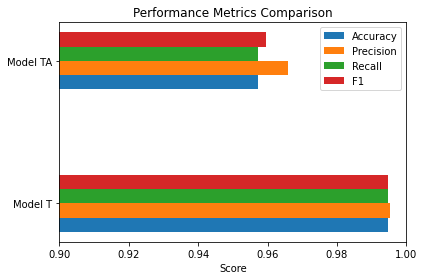

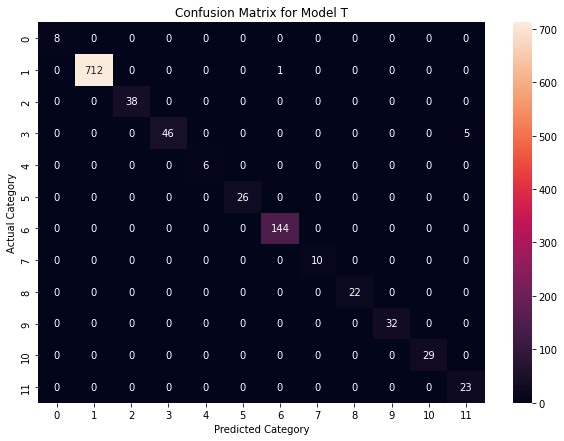

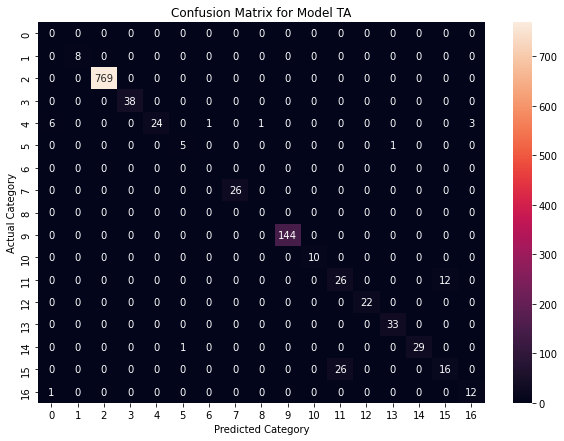

In [32]:
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

metrics = {}
for model, df in zip(['Model T', 'Model TA'], [gt_t_df, gt_ta_df]):
    accuracy = accuracy_score(df['finch_cat_id'], df['predicted_cat'])
    precision = precision_score(df['finch_cat_id'], df['predicted_cat'], average='weighted', zero_division=0)
    recall = recall_score(df['finch_cat_id'], df['predicted_cat'], average='weighted', zero_division=0)
    f1 = f1_score(df['finch_cat_id'], df['predicted_cat'], average='weighted', zero_division=0)

    metrics[model] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

fig, ax = plt.subplots()
models = list(metrics.keys())
performance_metrics = ['accuracy', 'precision', 'recall', 'f1']
model_positions = range(len(models)) 

for i, metric in enumerate(performance_metrics):
    values = [metrics[model][metric] for model in models]
    ax.barh([pos + i * 0.1 for pos in model_positions], values, height=0.1, label=f'{metric.capitalize()}')

ax.set_xlabel('Score')
ax.set_xbound(0.9, 1)
ax.set_title('Performance Metrics Comparison')
plt.yticks(ticks=[pos + 0.15 for pos in model_positions], labels=models)
ax.legend()

plt.tight_layout()
plt.show()

for model, df in zip(['Model T', 'Model TA'], [gt_t_df, gt_ta_df]):
    cm = confusion_matrix(df['finch_cat_id'], df['predicted_cat'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix for {model}')
    plt.ylabel('Actual Category')
    plt.xlabel('Predicted Category')
    plt.show()
